In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


# Read in data

In [119]:
train=pd.read_csv("/kaggle/input/tmdb-box-office-prediction/train.csv")
test=pd.read_csv("/kaggle/input/tmdb-box-office-prediction/test.csv")

## Seperate month and year into new features "month" and "year"

In [120]:
#keep for filling month and year (figure out how to handle years)
test.release_date.fillna("0/0", inplace=True)
train['month']=train['release_date'].apply(lambda x:x.split("/")[0])
test['month']=test['release_date'].apply(lambda x:x.split("/")[0])
train['year']=train['release_date'].apply(lambda x:x.split("/")[-1])
test['year']=test['release_date'].apply(lambda x:x.split("/")[-1])

## Turn "homepage" feature into binary as has homepage url feature

In [121]:
train['homepage'] = train['homepage'].notnull().astype(int)
test['homepage'] = test['homepage'].notnull().astype(int)

## Drop unuseful columns for model, and clean "belongs_to_collection" column to features "collection_name" and "has collection"

In [122]:
train.drop(columns=['id', 'imdb_id','poster_path', 'title','overview','original_title','tagline'], inplace=True)
test.drop(columns=['id', 'imdb_id','poster_path', 'title','overview','original_title','tagline'], inplace=True)

#Convert all Nans in belongs_to_collection to string
train['belongs_to_collection'].fillna('None', inplace=True)
test['belongs_to_collection'].fillna('None', inplace=True)

#Clean belongs_to_collection: use .eval for convert string to list
#Extracts 'name' from dictionary. Some of these are collections, while some are not.
#Store all the values from 'name' in new df column called 'collection_name'
train['collection_name'] = train[~(train['belongs_to_collection'] == 'None')]['belongs_to_collection'].apply(lambda x: eval(x)[0]['name'])
test['collection_name'] = test[~(test['belongs_to_collection'] == 'None')]['belongs_to_collection'].apply(lambda x: eval(x)[0]['name'])

#Update this new collection_name column. All the Nan values should have value 'none'
train.loc[(train['belongs_to_collection'] == 'None'), 'collection_name'] = 'None'
test.loc[(test['belongs_to_collection'] == 'None'), 'collection_name'] = 'None'

#all the words that don't have 'collection' in them are series, trilogies, or collections in other languages
#I am not dropping them, or changing their name to 'No Collection'
train.loc[(~(train['collection_name'] == 'None') & ~(train['collection_name'].str.contains('Collection'))), 'collection_name']
test.loc[(~(test['collection_name'] == 'None') & ~(test['collection_name'].str.contains('Collection'))), 'collection_name']

#Create binary column 'has_collection' with 0 or 1.
#As it turns out, only all the Nan (now None) converted to 0.
#All other titles (i.e. series, trilogies, collections, anthology) are converted to 1
train['has_collection'] = 0
train.loc[~(train['collection_name'] == 'None'), 'has_collection'] = 1
test['has_collection'] = 0
test.loc[~(test['collection_name'] == 'None'), 'has_collection'] = 1

## clean "genres" column to list of "genres_lst" for one hot encoding later

In [123]:
train['genres'].fillna('none', inplace=True)
train['genre_lst'] = train.loc[~(train['genres'] == 'none'), 'genres'].apply(lambda x: [item['name'] for item in eval(x)])
train['genre_lst'].fillna('none', inplace=True)
test['genres'].fillna('none', inplace=True)
test['genre_lst'] = test.loc[~(test['genres'] == 'none'), 'genres'].apply(lambda x: [item['name'] for item in eval(x)])
test['genre_lst'].fillna('none', inplace=True)

## do same with "spoken_languages" to "language_lst"

In [124]:
train['spoken_languages'].fillna('none', inplace=True)
train['language_lst'] = train.loc[~(train['spoken_languages'] == 'none'), 'spoken_languages'].apply(lambda x: [item['name'] for item in eval(x)])
train['language_lst'].fillna('none', inplace=True)
test['spoken_languages'].fillna('none', inplace=True)
test['language_lst'] = test.loc[~(test['spoken_languages'] == 'none'), 'spoken_languages'].apply(lambda x: [item['name'] for item in eval(x)])
test['language_lst'].fillna('none', inplace=True)

## convert "status" to a binary (has only two values, "released" and "rumored")

In [125]:
# Convert ‘status’ to binary (1 if not null, 0 if null) for train and test datasets
train['status'] = train['status'].notnull().astype(int)
test['status'] = test['status'].notnull().astype(int)

## Add missing runtimes to train and test data

In [126]:
#add runtimes
train['runtime'][2302]=86
train['runtime'][1335]=130
test['runtime'][243] = 93
test['runtime'][1489] = 91
test['runtime'][1632] = 100
test['runtime'][3817] = 90


# EDA visualizations

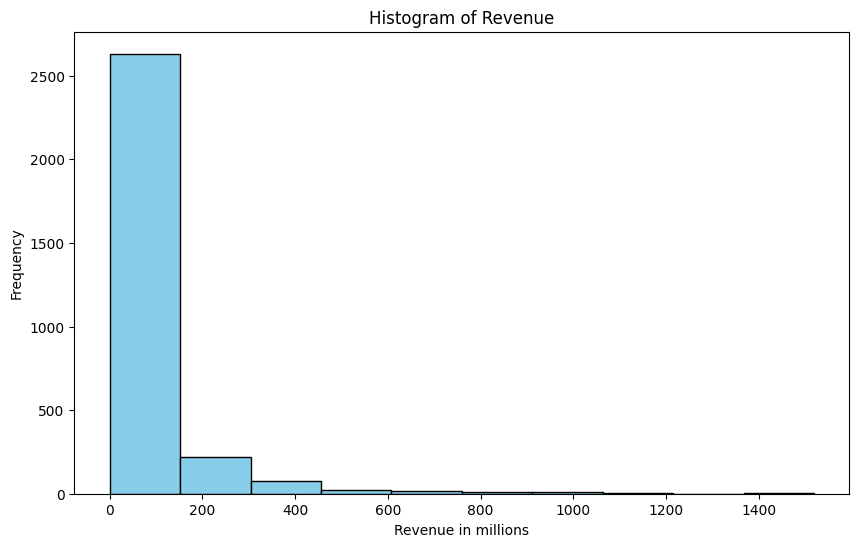

In [127]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(train['revenue']/1_000_000, bins=10, color='skyblue', edgecolor='black')  # You can adjust ‘bins’ to change the number of bins
plt.xlabel('Revenue in millions')
plt.ylabel('Frequency')
plt.title('Histogram of Revenue')
plt.show()

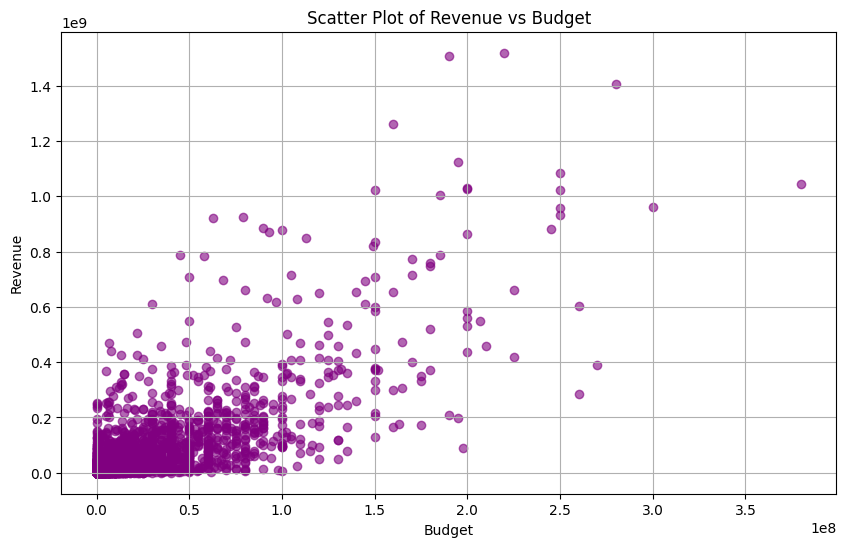

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(train['budget'], train['revenue'], color='purple', alpha=0.6)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Scatter Plot of Revenue vs Budget')
plt.grid(True)
plt.show()

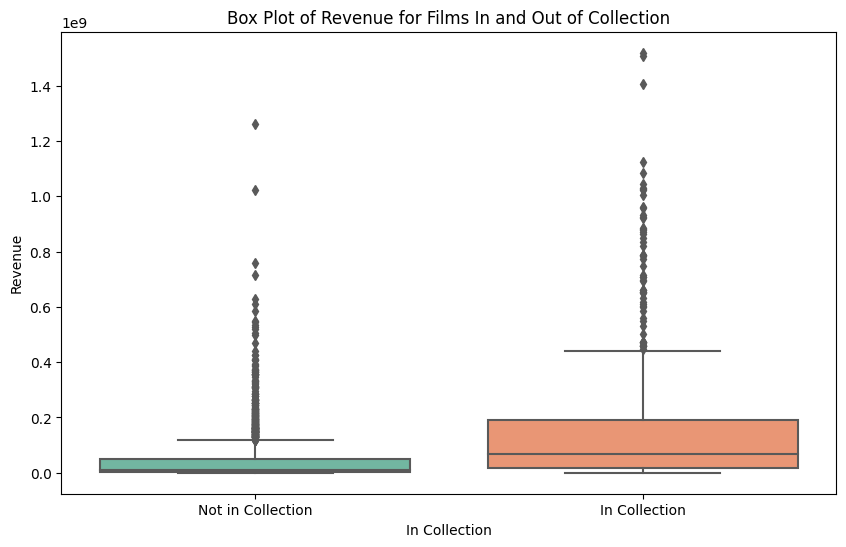

In [129]:
# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_collection', y='revenue', data=train, palette='Set2')
plt.xlabel('In Collection')
plt.ylabel('Revenue')
plt.title('Box Plot of Revenue for Films In and Out of Collection')
plt.xticks([0, 1], ['Not in Collection', 'In Collection'])  # Custom x-axis labels
plt.show()

## drop columns that have not yet been completely prepared, (to be cleaned and onehotencoded later)

In [145]:
temp_train=train.drop(columns=["genres",'production_companies','production_countries','spoken_languages','Keywords','cast','crew','belongs_to_collection','release_date', 'genre_lst', 'language_lst'])
temp_test=test.drop(columns=["genres",'production_companies','production_countries','spoken_languages','Keywords','cast','crew','belongs_to_collection','release_date','genre_lst', 'language_lst'])

# Seperate columns for scaling and one hot encoding

In [146]:
ohe_cols=['original_language','month','year','collection_name']
scale_cols=["budget", "runtime", "popularity"]

# Seperate features from labels/target

# One hot encode

In [147]:
ohe=OneHotEncoder(sparse_output = False,handle_unknown = 'ignore').set_output(transform='pandas')
transformed=ohe.fit( temp_train[ohe_cols])
transformed=ohe.transform( temp_train[ohe_cols])

transformed_test=ohe.transform(temp_test[ohe_cols]) #changed from fit transform

In [148]:
non_ohe_cols=[col for col in temp_train.columns if col not in ohe_cols]
non_ohe_cols.remove("revenue")
non_ohe_cols

['budget', 'homepage', 'popularity', 'runtime', 'status', 'has_collection']

In [149]:
train_ohe = pd.merge(train[non_ohe_cols], transformed, left_index=True, right_index=True)
test_ohe = pd.merge(test[non_ohe_cols], transformed_test, left_index=True, right_index=True)

In [152]:
# X=transformed.drop(columns='revenue')
y=train['revenue']

# Train test split

In [153]:
X_train, X_test, y_train, y_test = train_test_split(train_ohe,y, test_size=.2)

In [154]:
train_ohe.columns

Index(['budget', 'homepage', 'popularity', 'runtime', 'status',
       'has_collection', 'original_language_ar', 'original_language_bn',
       'original_language_cn', 'original_language_cs',
       ...
       'collection_name_Wonder Woman Collection',
       'collection_name_World War Z Collection',
       'collection_name_World of Watches Collection',
       'collection_name_Would I Lie to You? Collection',
       'collection_name_Wreck-It Ralph Collection',
       'collection_name_X-Men Collection', 'collection_name_Zorro Collection',
       'collection_name_[REC] Collection',
       'collection_name_Ирония судьбы (Коллекция)',
       'collection_name_Самый лучший фильм - Коллекция'],
      dtype='object', length=567)

# build pipelines / models

In [155]:
pipelr=Pipeline([("scale",MinMaxScaler()),

               ("model",LinearRegression())])

In [163]:
lr=LinearRegression()
lr.fit(train_ohe,y)
y_pred=lr.predict(X_test)
mean_squared_error(y_pred, y_test, squared=False)

60842848.22744078

In [164]:
lr.score(X_test,y_test)

0.8277158298587695

In [165]:
# lr=LinearRegression()
pipelr.fit(X_train,y_train)
y_pred=pipelr.predict(X_test)
mean_squared_error(y_pred, y_test, squared=False)
pipelr.score(X_test,y_test)

-4.287483176673854e+24

In [166]:
pipelas=Pipeline([("scale",MinMaxScaler()),

               ("model",Lasso())])

In [167]:
pipelas.fit(train_ohe,y)
# print(pipelas.score(X_test,y_test), pipelas.score(X_train,y_train))
# y_predlas=pipelas.predict(X_test)
# print(mean_squared_error(y_test,y_predlas, squared=False))

Pipeline(steps=[('scale', MinMaxScaler()), ('model', Lasso())])

In [169]:
test=pd.read_csv("/kaggle/input/tmdb-box-office-prediction/test.csv")

In [171]:
preds_test = lr.predict(test_ohe)
output = pd.DataFrame({'id': test["id"],
                       'revenue': preds_test})
output.to_csv('submission.csv', index=False)